In [ ]:
# Import necessary libraries
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap.umap_ as umap
import gower
import seaborn as sns

# Compute pairwise distances if not already done
from sklearn.metrics import pairwise_distances


c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notes

has gfüeu isch chli überlade at this point

<br><br>
# Hands-On: Dimensionality Reduction and Similarity

In this Hands-On we look at tools that we can use if we try to visualize high-dimensional data. We will first introduce the concepts by using a popular dataset for digit recognition (MNIST), later we will transfer these techniques to a dataset in the medical domain.


## Introduction to the MNIST Dataset

The **MNIST dataset** (Modified National Institute of Standards and Technology) is a classic collection of handwritten digit images, widely used as a benchmark for machine learning algorithms, especially in the fields of image classification and dimensionality reduction.

- **Images:** 70,000 images of handwritten digits (0–9), each sized 28×28 pixels
- **Training set:** 60,000 images
- **Test set:** 10,000 images
- **Pixel values:** Grayscale, ranging from 0 (white) to 255 (black)
- **Labels:** Each image is labeled with the digit it represents (0–9)
- **Data format:** Each 28×28 image is often "flattened" into a 784-dimensional vector for analysis (High-Dimension!)

**Why MNIST?**  
Although MNIST is not a medical dataset, it provides a simple and visual way to understand techniques like dimensionality reduction and similarity search, which are also applicable to healthcare data (e.g., recognizing patterns in medical images).

MNIST’s simplicity and accessibility have made it a standard tool for testing and comparing algorithms.

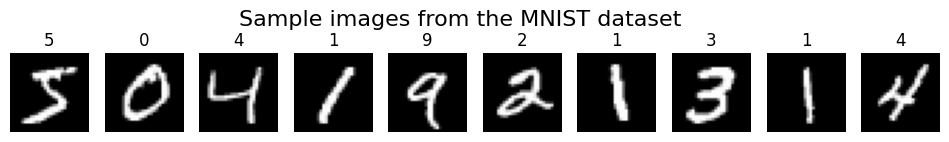

In [2]:
# Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)  # Convert labels to int

# Display 10 sample images
fig, axes = plt.subplots(1, 10, figsize=(12, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap="gray")
    ax.set_title(str(y[i]), fontsize=12)
    ax.axis("off")
plt.suptitle("Sample images from the MNIST dataset", fontsize=16, y=1.05)
plt.show()

# 1. Visualization with Dimensionality Reduction

Many real-world datasets, like images, have hundreds or thousands of features, making them impossible to visualize directly. **Dimensionality reduction** techniques help us project such high-dimensional data into 2 or 3 dimensions, allowing us to visualize and better understand the structure and patterns within the data.

## Principal Component Analysis (PCA)

**Principal Component Analysis (PCA)** is a fundamental technique for dimensionality reduction. It transforms high-dimensional data into a lower-dimensional space while preserving as much variability (information) as possible.

- **How does it work?**  
  PCA identifies the directions (principal components) where the data varies the most. The first principal component captures the most variance, the second is orthogonal to the first and captures the next highest variance, and so on.
- **Why use it?**  
  By projecting high-dimensional data onto the first few principal components, we can visualize complex datasets and uncover their underlying structure.

In this step, we'll project the 784-dimensional MNIST images onto the first two principal components and visualize the result.

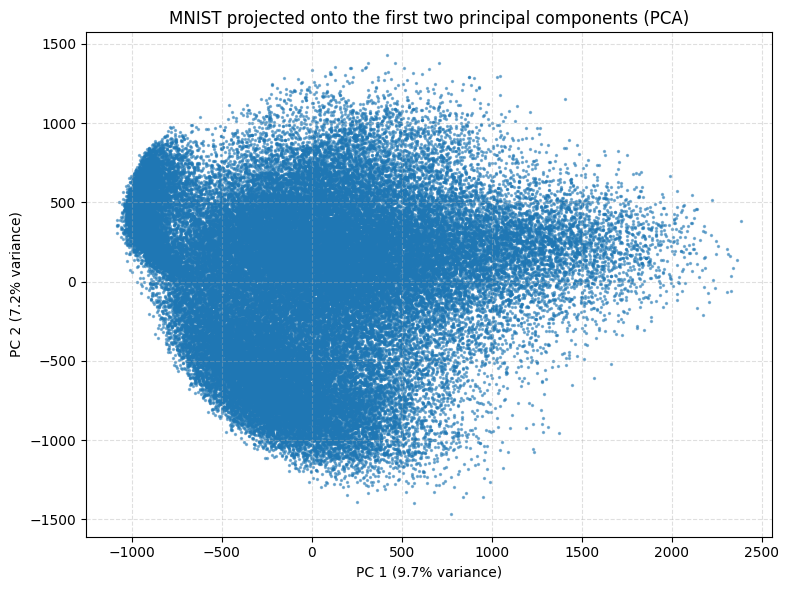

In [11]:
# Choose how many samples to visualize, later we use a subset for efficiency
n_samples = 70000
X_subset = X[:n_samples]
y_pca = y[:n_samples].astype(int)

# Fit PCA and transform the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

# Plot the PCA projection (without coloring by label yet)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=2, alpha=0.5)
plt.xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("MNIST projected onto the first two principal components (PCA)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

The scatter plot above displays each MNIST image as a point, projected onto the first two principal components.  
- **PC 1 and PC 2** represent the directions of greatest variance in the dataset.
- The **explained variance percentages** in the axis labels indicate how much of the dataset’s total variability is captured by each component. In this case *PC1* explains 9.7% of the variance in the data and *PC2* explains 7.2%.

At this stage, we’re not using any color to represent the digit labels.  
In the next step, we’ll color the points to explore how different digits are distributed in this reduced space.

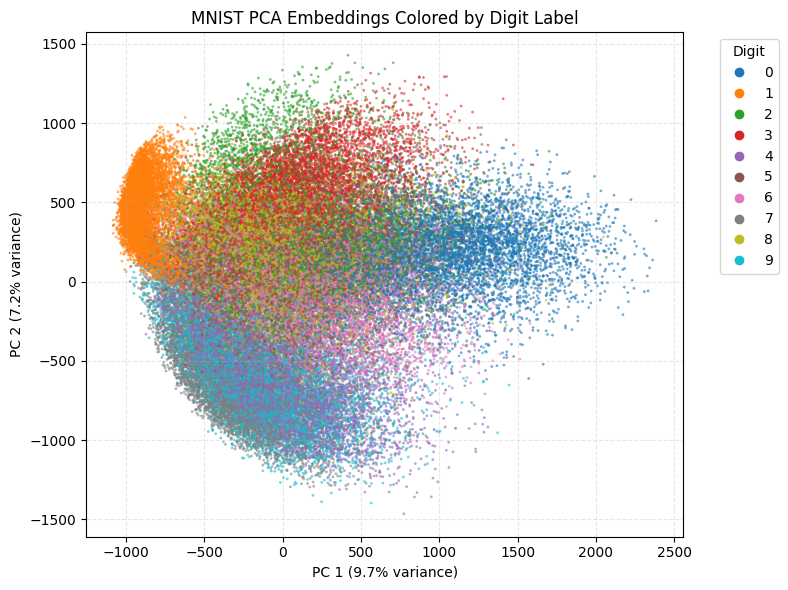

In [12]:
# Make sure y is an integer array for color mapping
labels = y_pca.astype(int)

# Create a color map: one unique color for each digit
cmap = plt.get_cmap('tab10', 10)  # 'tab10' has 10 distinct colors

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=labels,
    cmap=cmap,
    s=4,
    alpha=0.6,
    edgecolors='none'
)

# Create a legend, one entry per digit
legend_labels = [str(i) for i in range(10)]
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=cmap(i), label=legend_labels[i])
    for i in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("MNIST PCA Embeddings Colored by Digit Label")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

As we can see in the plot above, images of the digit **1** tend to cluster closely together, indicating that their representations are quite consistent in the PCA-reduced space. In contrast, images of the other digits are more spread out and often overlap with each other.

## Multidimensional Scaling (MDS)

**Multidimensional Scaling (MDS)** is another dimensionality reduction technique.  
Instead of focusing on variance (like PCA), MDS aims to preserve the pairwise distances between samples when projecting high-dimensional data into a lower-dimensional space. This can reveal different structures and relationships within the dataset.

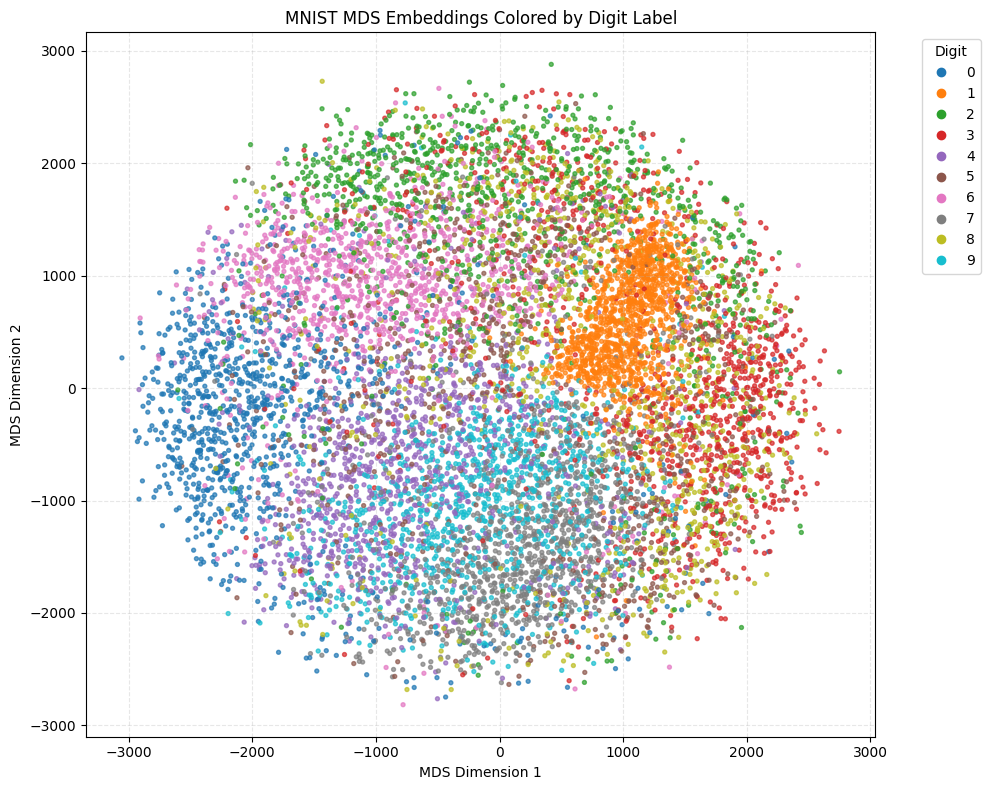

In [ ]:
# MDS can be slow on large datasets. For demonstration, we'll use a subset.
n_samples = 1000  # You can increase if your machine allows
X_subset = X[:n_samples]
y_mds = y[:n_samples].astype(int)

# Fit and transform with MDS
mds = MDS(n_components=2, random_state=42, n_init=1, max_iter=300, verbose=1)
X_mds = mds.fit_transform(X_subset)

# Plot the MDS embeddings colored by digit label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_mds[:, 0], X_mds[:, 1],
    c=y_mds,
    cmap=plt.get_cmap('tab10', 10),
    s=8, alpha=0.7
)
# Create a legend for digit labels
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=str(i))
    for i in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("MNIST MDS Embeddings Colored by Digit Label")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

**t-SNE** is a popular nonlinear dimensionality reduction algorithm, especially useful for visualizing high-dimensional data.  
Unlike PCA or MDS, t-SNE is designed to preserve local structure, meaning that similar points in high-dimensional space stay close together in the lower-dimensional map. This often results in clearer clusters for data like images or text.

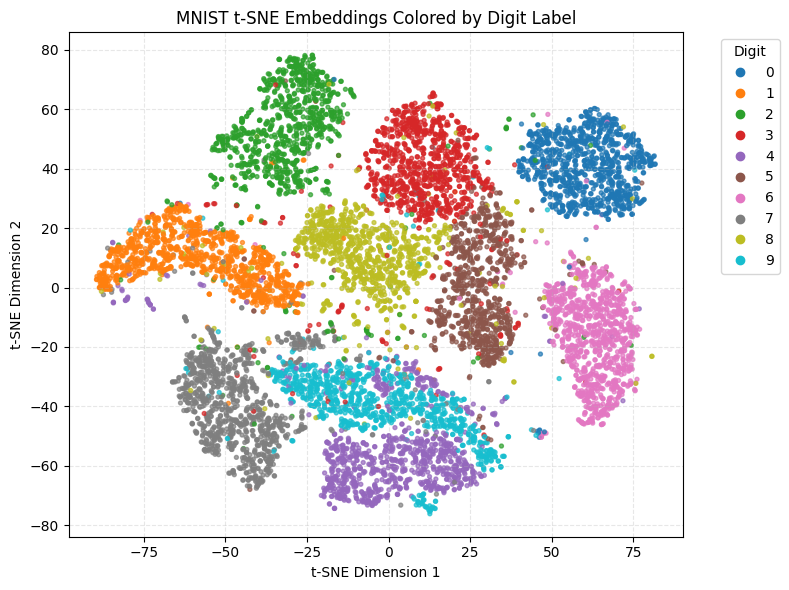

In [15]:
# t-SNE is computationally intensive; use a manageable subset
n_samples = 10000  # Adjust as needed for speed
X_subset = X[:n_samples]
y_tsne = y[:n_samples].astype(int)

# Fit and transform with t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
X_tsne = tsne.fit_transform(X_subset)

# Plot the t-SNE embeddings colored by digit label
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=y_tsne,
    cmap=plt.get_cmap('tab10', 10),
    s=8, alpha=0.7
)
# Create a legend for digit labels
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=str(i))
    for i in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("MNIST t-SNE Embeddings Colored by Digit Label")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Uniform Manifold Approximation and Projection (UMAP)

**UMAP** is a powerful nonlinear dimensionality reduction technique, similar to t-SNE but often faster and better at preserving both local and global data structure.  
UMAP is widely used for visualizing high-dimensional datasets, revealing clusters and patterns that might not be visible with linear methods like PCA.

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


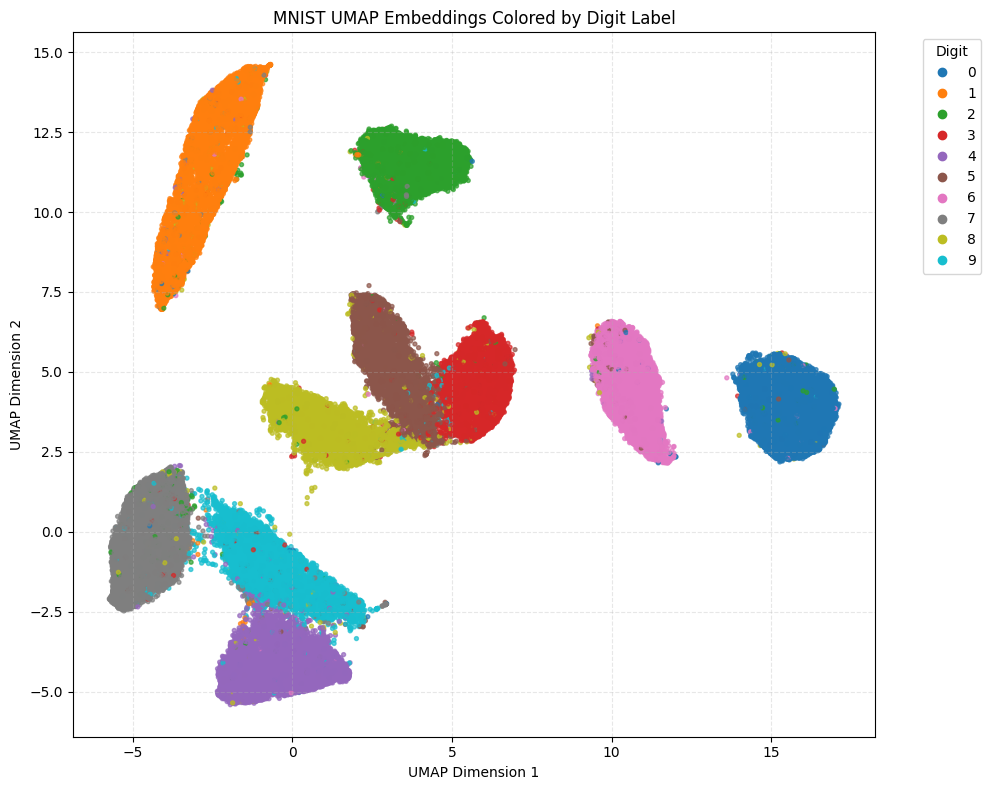

In [7]:
# UMAP is efficient but we'll still use a subset for consistency
n_samples = 70000
X_subset = X[:n_samples]
y_umap = y[:n_samples].astype(int)

# Fit and transform with UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_reducer.fit_transform(X_subset)

# Plot the UMAP embeddings colored by digit label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=y_umap,
    cmap=plt.get_cmap('tab10', 10),
    s=8, alpha=0.7
)
# Create a legend for digit labels
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=str(i))
    for i in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("MNIST UMAP Embeddings Colored by Digit Label")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Dimensionality Reduction Overview

Here is a brief summary of the four dimensionality reduction techniques we explored:

- **PCA (Principal Component Analysis):**  
  A linear technique that projects data onto the directions of greatest variance. Fast and interpretable, but may not reveal complex, nonlinear structures.

- **MDS (Multidimensional Scaling):**  
  Preserves the pairwise distances between samples as much as possible in the lower-dimensional embedding. Useful for visualizing similarity relationships.

- **t-SNE (t-Distributed Stochastic Neighbor Embedding):**  
  A nonlinear method that focuses on preserving local neighborhood structure, often revealing clusters more clearly than linear methods, but can distort global relationships.

- **UMAP (Uniform Manifold Approximation and Projection):**  
  A fast and flexible nonlinear method that preserves both local and some global structure. Often produces clear, meaningful clusters and scales well to large datasets.

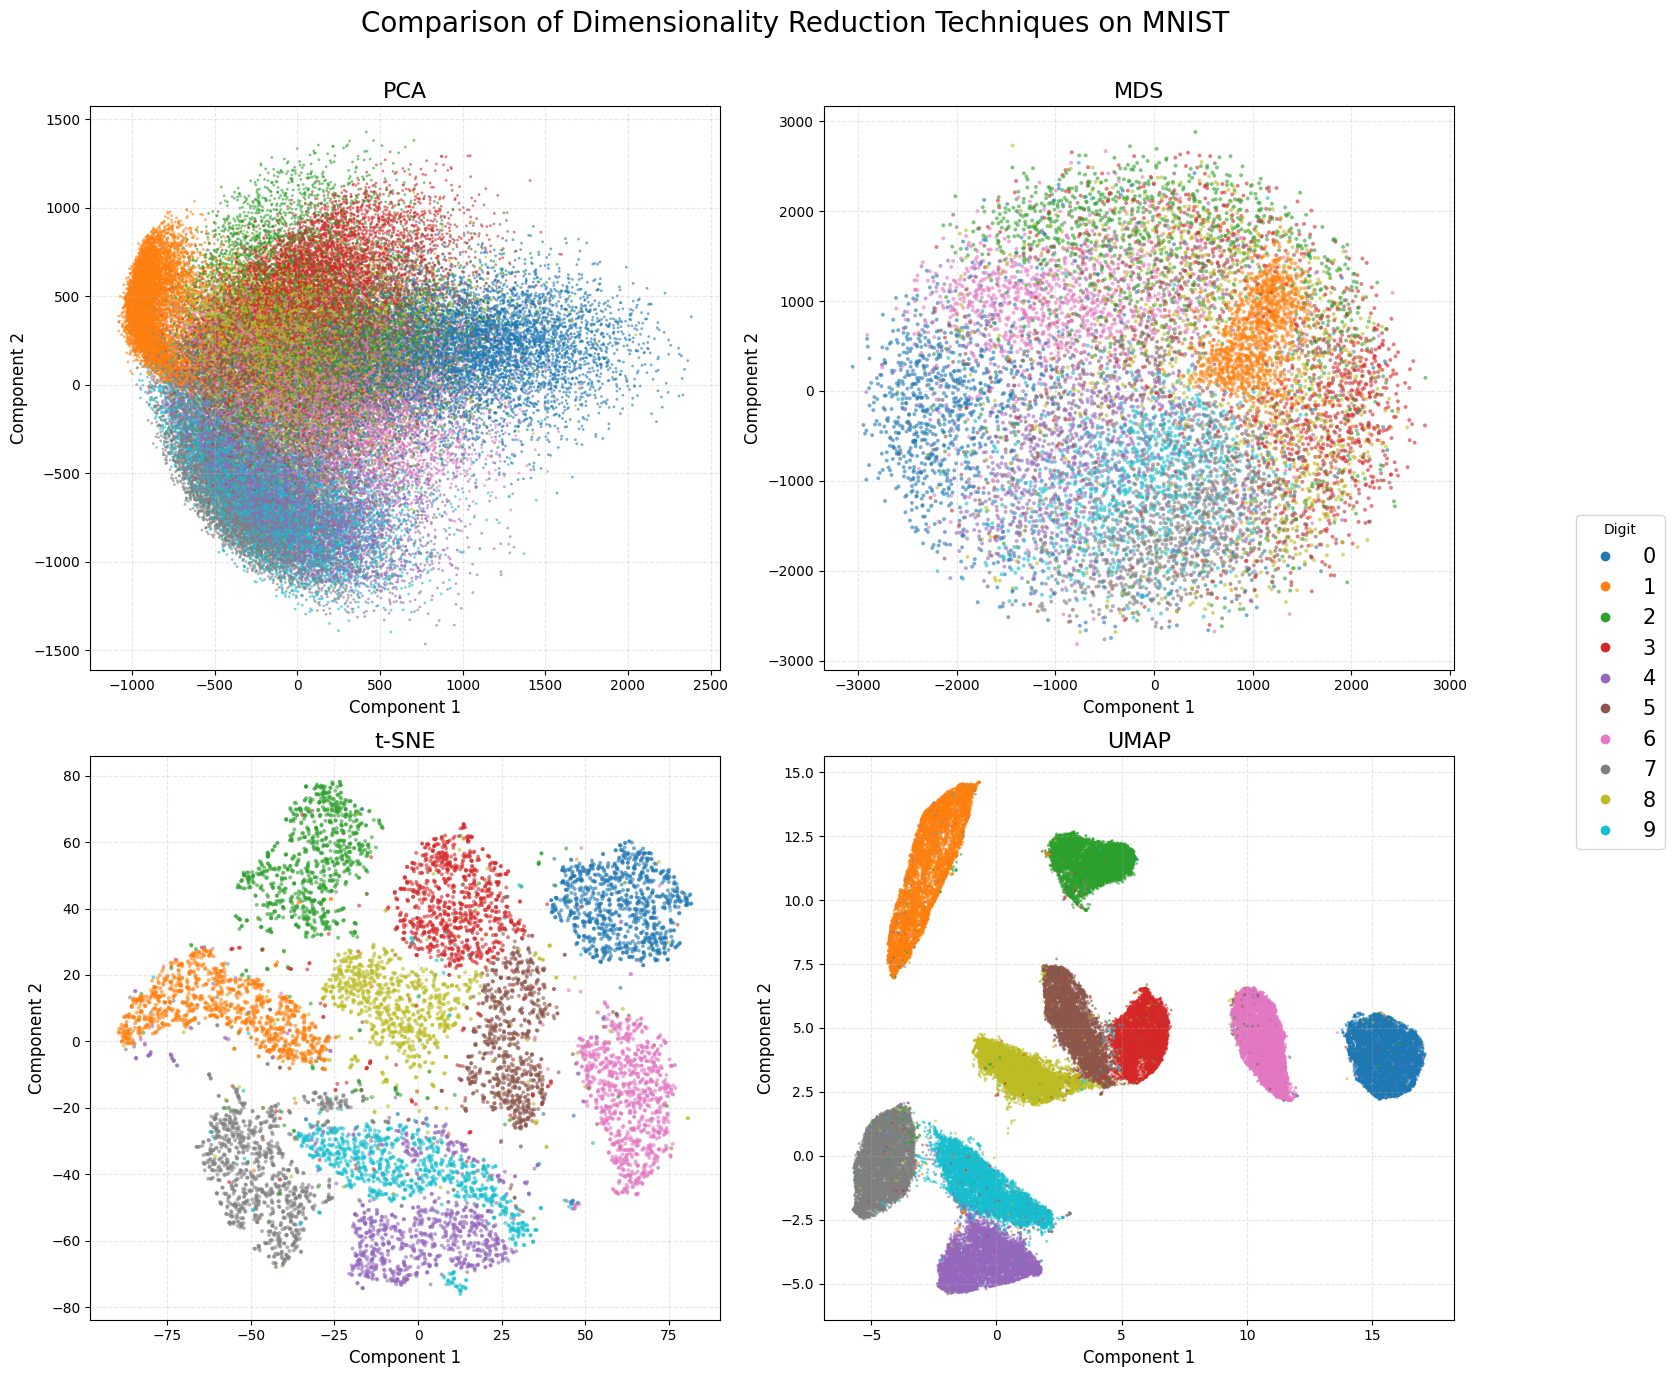

In [19]:
import matplotlib.pyplot as plt

# Each embedding and label set
embeddings = [
    (X_pca, y_pca, "PCA"),
    (X_mds, y_mds, "MDS"),
    (X_tsne, y_tsne, "t-SNE"),
    (X_umap, y_umap, "UMAP"),
]

cmap = plt.get_cmap('tab10', 10)

fig, axs = plt.subplots(2, 2, figsize=(16, 14))

for ax, (emb, labels, title) in zip(axs.flat, embeddings):
    sc = ax.scatter(
        emb[:, 0], emb[:, 1],
        c=labels.astype(int),
        cmap=cmap,
        s=4 if len(labels) > 10000 else 8,  # Smaller points for larger sets
        alpha=0.6,
        edgecolors='none'
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Component 1", fontsize=12)
    ax.set_ylabel("Component 2", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)

# Legend (only once for all plots)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=cmap(i), label=str(i))
    for i in range(10)
]
fig.legend(handles=handles, title="Digit", loc='center right', bbox_to_anchor=(1.05, 0.5), fontsize=15)

plt.suptitle("Comparison of Dimensionality Reduction Techniques on MNIST", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 0.93, 0.97])
plt.show()

<br><br>
# 2. Similarity and Dissimilarity

Understanding how similar or different data points are is fundamental in many machine learning tasks, such as clustering, classification, and recommendation systems. This section explores various distance and similarity metrics for different data types.

## Similarity Metrics for Numerical data

For continuous, numerical data, different distance metrics capture different notions of similarity. Two commonly used metrics are:

- **Euclidean distance:** Straight-line ("as the crow flies") distance between two points.
- **Manhattan distance:** Sum of absolute differences ("city block" or "taxicab" distance).

Let's demonstrate both on the MNIST dataset (using the first 10 images). As a reminder, here are the first 10 images again.

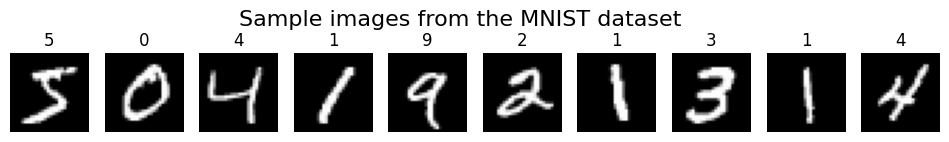

In [35]:
# Display 10 sample images
fig, axes = plt.subplots(1, 10, figsize=(12, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap="gray")
    ax.set_title(str(y[i]), fontsize=12)
    ax.axis("off")
plt.suptitle("Sample images from the MNIST dataset", fontsize=16, y=1.05)
plt.show()

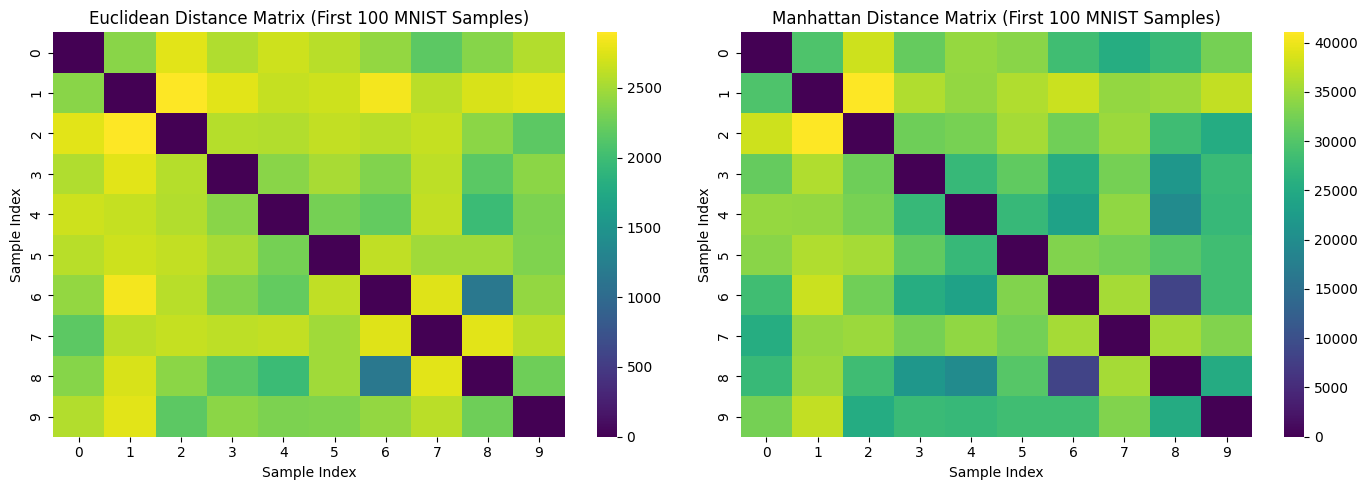

In [53]:
# Use a small subset for demonstration
X_num = X[:10]

dist_euclidean = pairwise_distances(X_num, metric='euclidean')
dist_manhattan = pairwise_distances(X_num, metric='manhattan')

plt.figure(figsize=(14, 5))

# Euclidean Distance Matrix
plt.subplot(1, 2, 1)
sns.heatmap(dist_euclidean, cmap='viridis')
plt.title('Euclidean Distance Matrix (First 100 MNIST Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')

# Manhattan Distance Matrix
plt.subplot(1, 2, 2)
sns.heatmap(dist_manhattan, cmap='viridis')
plt.title('Manhattan Distance Matrix (First 100 MNIST Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')

plt.tight_layout()
plt.show()

In [ ]:
TODO: Add some text here + Visualize the distance matrices

## Similarity Metrics for Categorical Data

For datasets that only contain categorical variables, different similarity and dissimilarity measures are used:

maybe move this list below the dataset

- **Simple Matching Coefficient (SMC):** Proportion of matching attributes.
- **Jaccard Coefficient:** Proportion of shared "positive" attributes, ignoring double negatives.
- **Hamming Distance:** Number of positions with different symbols.

Let's use a dataset that only contains categorical values now.

## Introduction to the Mushroom Dataset

The **Mushroom dataset** is a classic collection from the UCI Machine Learning Repository, widely used for demonstrating machine learning algorithms with categorical data.  
It contains records of mushroom specimens found in the wild, described by various physical characteristics.

- **Samples:** 8,124 mushrooms
- **Features:** 22 categorical attributes (e.g., cap shape, color, odor, gill size)
- **Target labels:**  
  - `e` = edible  
  - `p` = poisonous
- **Data type:** All variables are **categorical** (letters representing categories)
- **Missing values:** Some are marked with `?` (e.g., for stalk-root)

**Why the Mushroom dataset?**  
This dataset is ideal for exploring similarity and dissimilarity measures for categorical data, because:
- All features are discrete and interpretable
- The classification task (edible vs. poisonous) is clear and relevant
- The dataset is large enough for robust analysis but small enough for quick experimentation

The Mushroom dataset is a standard benchmark for testing algorithms that handle categorical and mixed-type features.


TODO: Maybe skip this example
### Example: Distribution of Edible vs. Poisonous Mushrooms

Below, we visualize the class balance and a few feature value distributions from the Mushroom dataset.

In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load Mushroom dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape",
    "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]
df = pd.read_csv(url, names=columns)

# Use only the first 10 samples for clarity
df_cat = df.iloc[:10, 1:]  # Exclude the class label for distance

# Encode all categorical features numerically
le_dict = {}
df_enc = df_cat.copy()
for col in df_cat.columns:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_cat[col])
    le_dict[col] = le

X_cat = df_enc.values

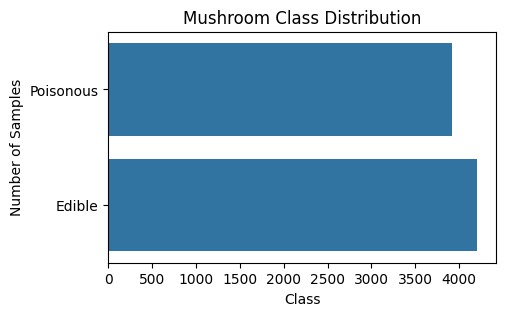

C:\Users\janic\AppData\Local\Temp\ipykernel_89460\600673973.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df[feat], ax=ax, order=df[feat].value_counts().index, palette='viridis')
C:\Users\janic\AppData\Local\Temp\ipykernel_89460\600673973.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df[feat], ax=ax, order=df[feat].value_counts().index, palette='viridis')
C:\Users\janic\AppData\Local\Temp\ipykernel_89460\600673973.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df[feat], ax=ax, order=df[feat].value_counts().index, pa

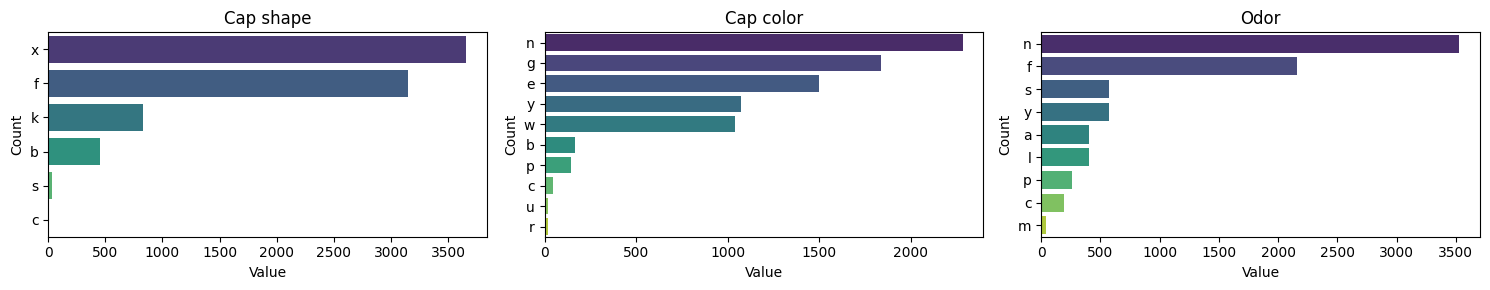

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
plt.figure(figsize=(5, 3))
sns.countplot(df['class'].map({'e': 'Edible', 'p': 'Poisonous'}))
plt.title('Mushroom Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Example categorical features
features = ['cap-shape', 'cap-color', 'odor']
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for ax, feat in zip(axes, features):
    sns.countplot(df[feat], ax=ax, order=df[feat].value_counts().index, palette='viridis')
    ax.set_title(f'{feat.replace("-", " ").capitalize()}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

TODO: Add text as a transition to the metrics

In [47]:
import numpy as np

def simple_matching(a, b):
    return np.mean(a == b)

# Compute SMC matrix
n_samples = X_cat.shape[0]
smc_matrix = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        smc_matrix[i, j] = simple_matching(X_cat[i], X_cat[j])

print("Simple Matching Coefficient matrix (first 3 rows):\n", smc_matrix[:3, :3])

Simple Matching Coefficient matrix (first 3 rows):
 [[1.         0.68181818 0.59090909]
 [0.68181818 1.         0.77272727]
 [0.59090909 0.77272727 1.        ]]


In [48]:
from sklearn.metrics import jaccard_score

# One-hot encode for Jaccard
df_onehot = pd.get_dummies(df_cat)
X_onehot = df_onehot.values

# Compute Jaccard matrix (samples vs. samples)
jac_matrix = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        jac_matrix[i, j] = jaccard_score(X_onehot[i], X_onehot[j])

print("Jaccard Coefficient matrix (first 3 rows):\n", jac_matrix[:3, :3])

Jaccard Coefficient matrix (first 3 rows):
 [[1.         0.51724138 0.41935484]
 [0.51724138 1.         0.62962963]
 [0.41935484 0.62962963 1.        ]]


In [49]:
from scipy.spatial.distance import hamming

# Compute Hamming distance matrix
ham_matrix = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        ham_matrix[i, j] = hamming(X_cat[i], X_cat[j])  # normalized (0 to 1)

print("Hamming Distance matrix (first 3 rows):\n", ham_matrix[:3, :3])

Hamming Distance matrix (first 3 rows):
 [[0.         0.31818182 0.40909091]
 [0.31818182 0.         0.22727273]
 [0.40909091 0.22727273 0.        ]]


We use the Mushroom dataset (all categorical) to compute:

- **Simple Matching Coefficient:** Fraction of matching attributes between two mushrooms.
- **Jaccard Coefficient:** Fraction of shared positive attributes (after one-hot encoding).
- **Hamming Distance:** Fraction of differing attributes.

The heatmaps below illustrate the similarities and differences between the first 10 mushrooms in the dataset.

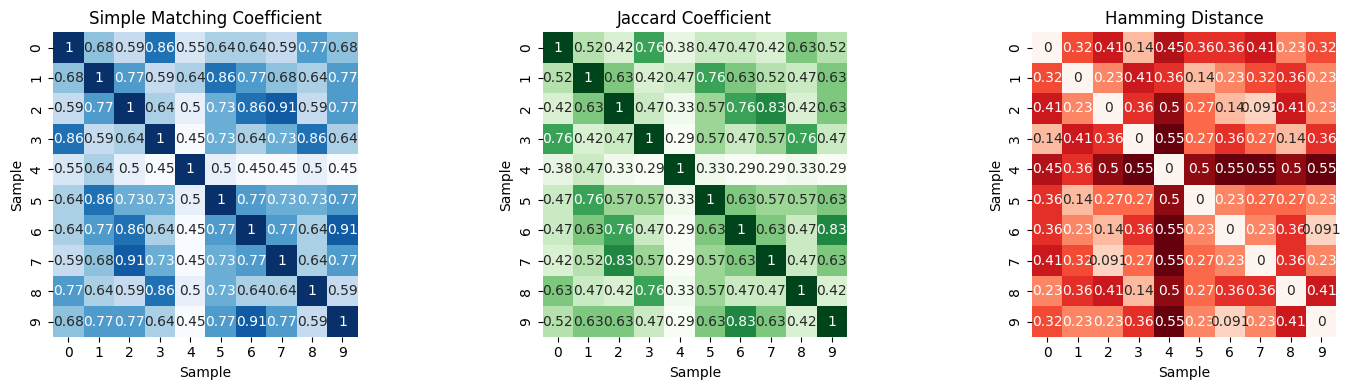

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.heatmap(smc_matrix, annot=True, cmap='Blues', square=True, cbar=False)
plt.title("Simple Matching Coefficient")
plt.xlabel("Sample")
plt.ylabel("Sample")

plt.subplot(1, 3, 2)
sns.heatmap(jac_matrix, annot=True, cmap='Greens', square=True, cbar=False)
plt.title("Jaccard Coefficient")
plt.xlabel("Sample")
plt.ylabel("Sample")

plt.subplot(1, 3, 3)
sns.heatmap(ham_matrix, annot=True, cmap='Reds', square=True, cbar=False)
plt.title("Hamming Distance")
plt.xlabel("Sample")
plt.ylabel("Sample")

plt.tight_layout()
plt.show()

In [ ]:
TODO: Add some text + Visualize the distance matrices

### Gower's Dissimilarity for Mixed Data Types TODO

When datasets contain both continuous and categorical features, **Gower's distance** provides a way to compute dissimilarity. 

Let's look at the dataset

## Introduction to the Titanic Dataset

The **Titanic dataset** is a famous collection of passenger records from the RMS Titanic, widely used for teaching and benchmarking in machine learning and statistics. It contains both numerical and categorical features, making it ideal for exploring similarity measures for mixed data.

- **Samples:** 891 passengers (training set)
- **Features:**  
  - **Numerical:** Age, Fare, Number of siblings/spouses (`SibSp`), Number of parents/children (`Parch`)
  - **Categorical:** Sex, Passenger class (`Pclass`), Embarked port, Ticket, Cabin (often simplified)
- **Target label:** `Survived` (0 = No, 1 = Yes)
- **Data types:** Mixture of categorical and continuous variables
- **Missing values:** Some features (e.g., Age, Cabin) contain missing data

**Why the Titanic dataset?**  
- It exemplifies real-world data with a mix of variable types.
- The variable meanings are easily interpretable.
- It's a classic for demonstrating the challenges and techniques of handling mixed data in clustering and similarity analysis.

The Titanic dataset is a standard tool for introducing and testing distance metrics like **Gower’s dissimilarity**, which can compare records with both continuous and categorical features.


TODO: Maybe skip this example

### Example: Distribution of Survival and Selected Features

Below, we visualize the survival outcome and the distributions of some key features in the Titanic dataset.

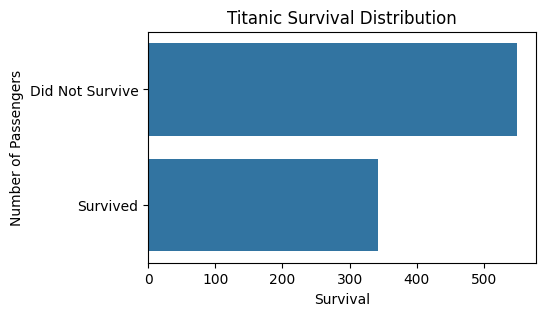

C:\Users\janic\AppData\Local\Temp\ipykernel_89460\3784104374.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(titanic['sex'], ax=axes[0], palette='Set2')
C:\Users\janic\AppData\Local\Temp\ipykernel_89460\3784104374.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(titanic['pclass'], ax=axes[1], palette='Set3', hue=None, legend=False)


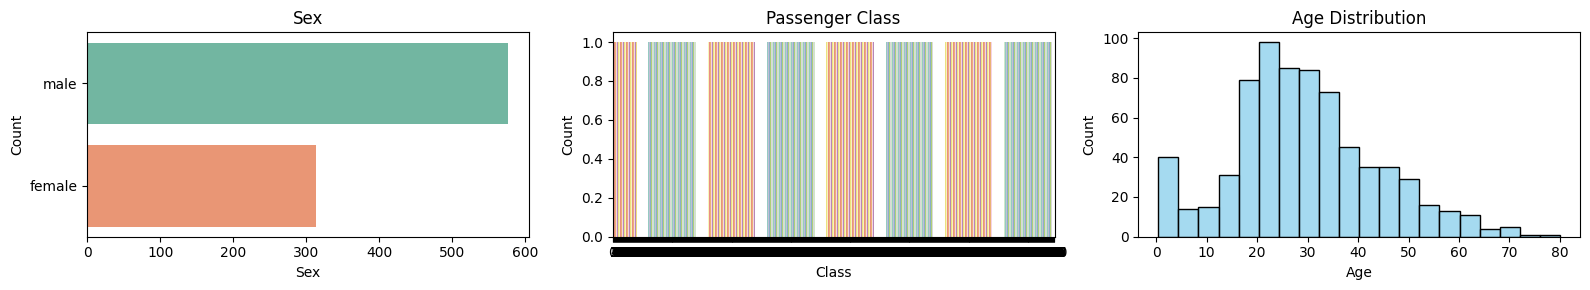

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load Titanic dataset from seaborn
titanic = sns.load_dataset('titanic')

# Drop rows with missing target for simplicity
titanic = titanic.dropna(subset=['survived'])

# Plot survival distribution
plt.figure(figsize=(5, 3))
sns.countplot(titanic['survived'].map({0: 'Did Not Survive', 1: 'Survived'}))
plt.title('Titanic Survival Distribution')
plt.xlabel('Survival')
plt.ylabel('Number of Passengers')
plt.show()

# Plot a few mixed-type features
features = ['sex', 'pclass', 'age']
fig, axes = plt.subplots(1, 3, figsize=(16, 3))

sns.countplot(titanic['sex'], ax=axes[0], palette='Set2')
axes[0].set_title('Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')

sns.countplot(titanic['pclass'], ax=axes[1], palette='Set3', hue=None, legend=False)
axes[1].set_title('Passenger Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

sns.histplot(titanic['age'].dropna(), bins=20, ax=axes[2], color='skyblue')
axes[2].set_title('Age Distribution')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [61]:
# Select features for Gower (mix of categorical & numeric, no missing values)
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

# Drop rows with missing values in selected features
titanic_gower = titanic[features].dropna().reset_index(drop=True)

# Calculate Gower dissimilarity matrix
gower_matrix = gower.gower_matrix(titanic_gower)

print("Gower dissimilarity matrix shape:", gower_matrix.shape)
print("First 5x5 block:\n", gower_matrix[:5, :5])

Gower dissimilarity matrix shape: (712, 712)
First 5x5 block:
 [[0.         0.47514862 0.17879735 0.32183585 0.0521313 ]
 [0.47514862 0.         0.35349414 0.15331276 0.48016018]
 [0.17879735 0.35349414 0.         0.20018137 0.15904824]
 [0.32183585 0.15331276 0.20018137 0.         0.3268474 ]
 [0.0521313  0.48016018 0.15904824 0.3268474  0.        ]]


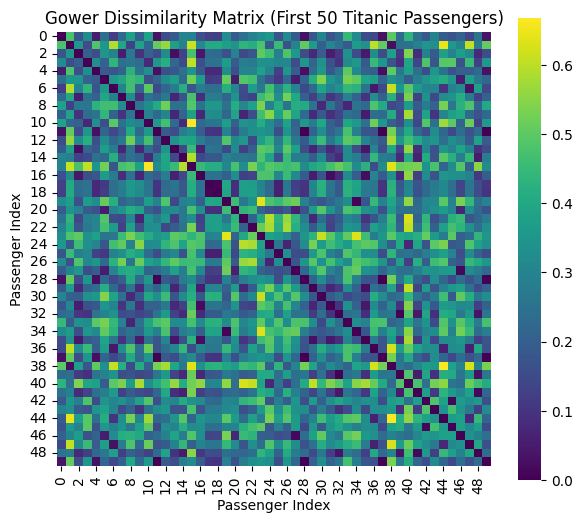

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# To keep it visually clear, use only the first 50 passengers
gower_matrix_vis = gower_matrix[:50, :50]

plt.figure(figsize=(7, 6))
sns.heatmap(gower_matrix_vis, cmap='viridis', square=True)
plt.title("Gower Dissimilarity Matrix (First 50 Titanic Passengers)")
plt.xlabel("Passenger Index")
plt.ylabel("Passenger Index")
plt.show()

Visualize the matrix with mds, t-sne, umap

<br><br>
# 4. Transfer to a clinical meaningful dataset

## Numerical

### Dataset description

### Dimensionality Reduction + Visualizations

### Similarity Matrix + Visualisations

## Categorical

### Dataset description

### Similarity Matrix + Visualisations

## Mixed

### Dataset description

### Similarity Matrix + Visualisatiosn